In [1]:
import DirectDmTargets as dddm

calculating effective efficancy for Xe detector done
calculating effective efficancy for Ar detector done
calculating effective efficancy for Ge detector done


In [2]:
import wimprates as wr

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import numericalunits as nu

In [5]:
from tqdm import tqdm

In [6]:
from scipy.integrate import quad as scipy_int

In [7]:
import pandas as pd

In [8]:
import scipy

In [9]:
import emcee
emcee.__version__

'3.0.0'

In [10]:
import corner

# Direct detection of Dark matter using different target materials #

Author:

Joran Angevaare <j.angevaare@nikef.nl>

Date:

14 october 2019 

## Goal ## 

- Roughly reproduce <https://journals.aps.org/prd/abstract/10.1103/PhysRevD.83.083505>
- Update the results thereof with more recent knowledge of the DM-distribution

### Approach ###
To achieve these goals, we must first get a decent recoil spectrum, that is flexible enough to have different astrophysical parameters. Further, it must also be flexible enough to be able to allow for different analytic functions to be added to the model. For instance, we must be able to incorporate the $\rm{SHM}^{++}$ as presented here <https://arxiv.org/abs/1810.11468>.

When we have a sufficiently flexible model, we want to add in the detector physics, we should therein incorporate at least the following parameters:
- target
  - material
  - cross-section
- threshold
- background
- cut efficiency  
- volume
- exposure

Finally we should perform the inference

# Emcee #
<https://emcee.readthedocs.io/en/stable/tutorials/quickstart/>

## Distribution of the DM ##
First we need to make a DM-rate spectrum

In [11]:
use_SHM = dddm.SHM()
xe_events = dddm.DetectorSpectrum(50, 1e-45, use_SHM, dddm.detectors['Xe'])
xe_data = xe_events.get_data(poisson = False)
xe_data

,counts,bin_centers,bin_left,bin_right
0,20.543476,5.0,0.0,10.0
1,156.624879,15.0,10.0,20.0
2,64.765430,25.0,20.0,30.0
3,22.123232,35.0,30.0,40.0
4,6.992244,45.0,40.0,50.0
5,2.005902,55.0,50.0,60.0
6,0.504013,65.0,60.0,70.0
7,0.103457,75.0,70.0,80.0
8,0.014957,85.0,80.0,90.0
9,0.001162,95.0,90.0,100.0


In [12]:
# xe_events = dddm.GenSpectrum(50, 1e-45, use_SHM, dddm.detectors['Xe'])
# xe_data = xe_events.get_data(poisson = False)

In [13]:
import multiprocessing

In [14]:
multiprocessing.cpu_count()

12

In [24]:
%%time
from multiprocessing import Pool
with Pool() as pool:
    nwalkers = 10
    step = 50
    pos = np.hstack(
        [50   + 3*10 * np.random.rand(nwalkers, 1) ,
        1e-45 + 1e-45 * np.random.rand(nwalkers, 1),
        230   + 3*30 * np.random.rand(nwalkers, 1),
        544   + 3*33 * np.random.rand(nwalkers, 1),
        0.4   + 3*0.1 * np.random.rand(nwalkers, 1)   
        ])
    nwalkers, ndim = pos.shape

    sampler = emcee.EnsembleSampler(nwalkers, ndim, 
                    dddm.log_probability_detector, args=(xe_data['bin_centers'],
                                                                xe_data['counts'],
                                                               ['log_mass',
                                                                'log_cross_section', 
                                                                'v_0',
                                                                'v_esc', 
                                                                'density']),
                                        pool=pool
                                   )
    sampler.run_mcmc(np.abs(pos), step, progress=False);

Wall time: 25.5 s


In [25]:
sampler.get_autocorr_time(c=1, quiet=True)

N/50 = 1;
tau: [6.77977888 7.45554479 6.92148052 4.87574265 4.65295296]


array([6.77977888, 7.45554479, 6.92148052, 4.87574265, 4.65295296])

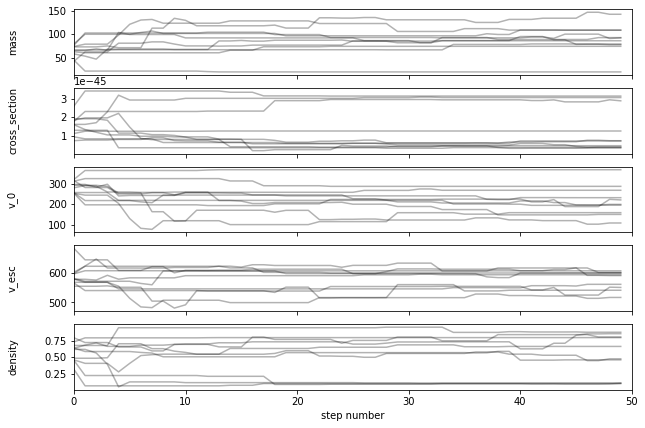

In [26]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ['mass',
                                          'cross_section', 
                                                            'v_0',
                                                            'v_esc', 
                                                            'density']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

(20, 5)


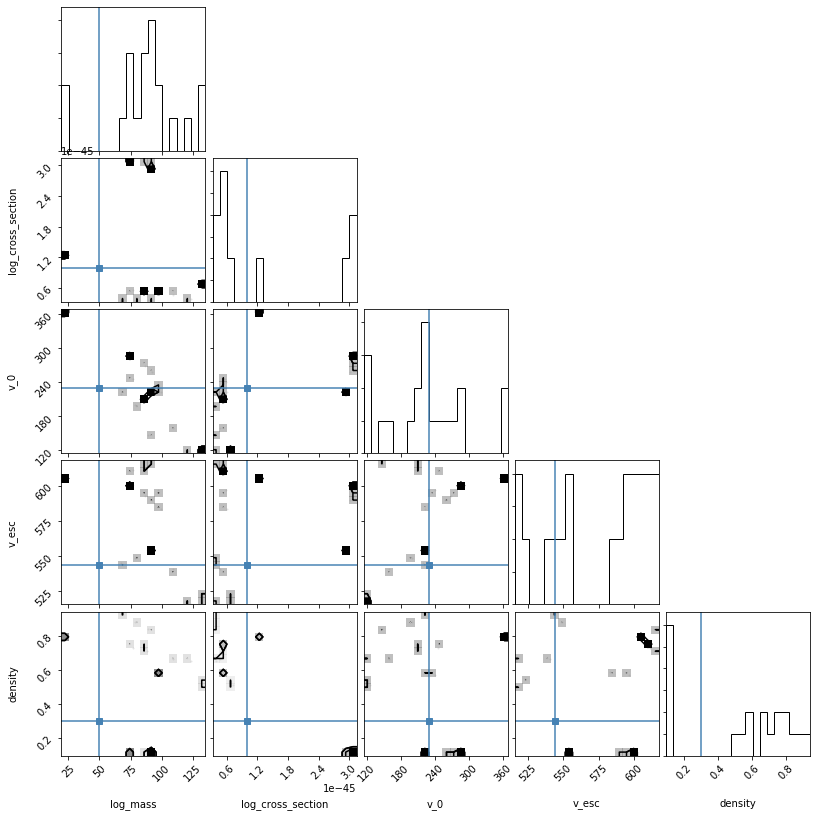

In [27]:
flat_samples = sampler.get_chain(discard=int(step*0.2), thin=15, flat=True)
print(flat_samples.shape)
fig = corner.corner(flat_samples, labels=['log_mass',
                                          'log_cross_section', 
                                                            'v_0',
                                                            'v_esc', 
                                                            'density'], 
                    truths=[50, 1e-45, 230, 544, 0.3]);

In [21]:
print("Mean acceptance fraction: {0:.3f}"
                .format(np.mean(sampler.acceptance_fraction)))

Mean acceptance fraction: 0.258
